<a href="https://colab.research.google.com/github/kevinkevin556/Dlchemist/blob/main/alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alexnet.png](https://github.com/kevinkevin556/Dlchemist/blob/main/images/alexnet_banner.png?raw=true)

This is an implementaiton of AlexNet, as introduced in the paper "ImageNet Classification with Deep Convolutional Neural Networks" by Alex Krizhevsky et al. ([original paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf))

# **Section 1. Set up**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### *Dataset and DataLoader*

In [ ]:
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize

transform = Compose([Resize(224), ToTensor()])

train_dataset = CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10('./data', train=False, download=True, transform=transform) 

train_dataset, valid_dataset = random_split(
    train_dataset, (0.8, 0.2), 
    generator = torch.Generator().manual_seed(42)
)

print("\nData Size:")
print("* Training set   => ", len(train_dataset), "images")
print("* Validation set => ", len(valid_dataset), "images")
print("* Testing set    => ", len(test_dataset), "images")

print("\nImage Shape (C, H, W):")
print("* Training image:", train_dataset[0][0].shape)
print("* Testing image: ", test_dataset[0][0].shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Data Size:
* Training set   =>  40000 images
* Validation set =>  10000 images
* Testing set    =>  10000 images

Image Shape (C, H, W):
* Training image: torch.Size([3, 224, 224])
* Testing image:  torch.Size([3, 224, 224])


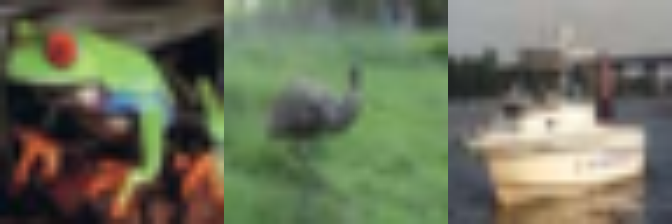

[6, 2, 8]


In [ ]:
n_view = 3
sample_images = [train_dataset[i][0] for i in range(n_view)]
sample_targets = [train_dataset[i][1] for i in range(n_view)]
display(ToPILImage()(torch.dstack(sample_images)))
print(sample_targets)

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

### *Network Structure*

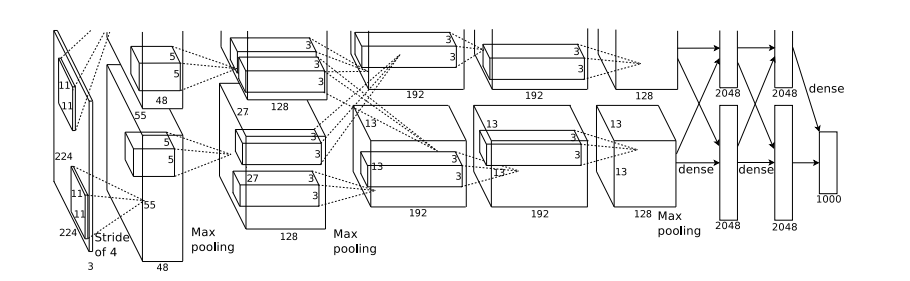

In [ ]:
from torch.nn import Conv2d, ReLU, MaxPool2d, Flatten, Linear, Sequential, Softmax

class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = Sequential()
    self.net.add_module("Conv1", Sequential(
          Conv2d(in_channels=3, out_channels=48*2, kernel_size=11, stride=4),
          ReLU(),
          MaxPool2d(kernel_size=3, stride=2)
    ))
    self.net.add_module("Conv2", Sequential(
          Conv2d(in_channels=48*2, out_channels=128*2, kernel_size=5, padding=2),
          ReLU(),
          MaxPool2d(kernel_size=3, stride=2)
    ))
    self.net.add_module("Conv3", Sequential(  
        Conv2d(in_channels=128*2, out_channels=192*2, kernel_size=3, padding=1),
        ReLU()
    ))
    self.net.add_module("Conv4", Sequential(
        Conv2d(in_channels=192*2, out_channels=192*2, kernel_size=3, padding=1),
        ReLU()
    ))
    self.net.add_module("Conv5", Sequential(
        Conv2d(in_channels=192*2, out_channels=128*2, kernel_size=3, padding=1),
        ReLU(),
        MaxPool2d(kernel_size=3, stride=2)
    ))

    self.net.add_module("_", Flatten())

    self.net.add_module("FullyConnected6-8", Sequential(
        Linear(in_features=256*5*5, out_features=2048*2),
        Linear(in_features=2048*2, out_features=4096*2),
        Linear(in_features=4096*2, out_features=num_classes)
    ))

  def forward(self, x):
    return self.net(x)

print(AlexNet())

AlexNet(
  (net): Sequential(
    (Conv1): Sequential(
      (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (Conv2): Sequential(
      (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (Conv3): Sequential(
      (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (Conv4): Sequential(
      (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (Conv5): Sequential(
      (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (_): Flatten(start_dim=1, end_dim=-1)
    (FullyConnected6-8): Sequential(
      (0): 

In [ ]:
# Check forward path
X = torch.randn(1, 3, 224, 224)
for layer in AlexNet().net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Sequential output shape:	 torch.Size([1, 10])


### *Test / Validation Step*

In [ ]:
def validate(model, dataloader, device=torch.device('cuda')):
  model.eval()
  acc = []

  with torch.no_grad():
    for images, targets in dataloader:
      images, targets = images.to(device), targets.to(device)
      preds = model(images)
      pred_labels = torch.argmax(preds, dim=1)
      acc.append((pred_labels == targets).type(torch.float32) .mean().item())
  
  return acc

### *Training Step*

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_dataloader,
    valid_dataloader,
    num_epochs = 1,
    device = torch.device('cuda'),
    state_dict = None
):
  
  best_valid_acc = 0
  
  if state_dict is not None:
    model.load_state_dict(state_dict)

  for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    train_progress = tqdm(train_dataloader, position=0, leave=True)

    ## Train
    for images, targets in train_progress:
      images, targets = images.to(device), targets.to(device)
      preds = model(images)
      loss = criterion(preds, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_value = loss.detach().item()
      batch_losses.append(loss_value)
      train_progress.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
      train_progress.set_postfix({'loss': loss_value})
    
    ## Validate and save the best model (if any)
    valid_acc = validate(model,  valid_dataloader)
    print(f"Train Loss: {np.mean(batch_losses):.3f}, Valid Acc:{np.mean(valid_acc):.3f}")
    if np.mean(valid_acc) > best_valid_acc:
      best_valid_acc = np.mean(valid_acc)
      torch.save(model.state_dict(), "model_state_dict.ckpt")

# **Section 2. Start Training**

### *Optimization Configuration and Training Stage*

In [ ]:
alexnet = AlexNet(num_classes=10)
alexnet.to(device)

optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train(alexnet, criterion, optimizer, train_dataloader, valid_dataloader, num_epochs=50)

Epoch [1/50]: 100%|██████████| 313/313 [01:34<00:00,  3.31it/s, loss=2.3]


Train Loss: 2.302, Valid Acc:0.134


Epoch [2/50]: 100%|██████████| 313/313 [01:28<00:00,  3.54it/s, loss=2.3]


Train Loss: 2.302, Valid Acc:0.101


Epoch [3/50]: 100%|██████████| 313/313 [01:26<00:00,  3.61it/s, loss=2.31]


Train Loss: 2.299, Valid Acc:0.099


Epoch [4/50]: 100%|██████████| 313/313 [01:26<00:00,  3.62it/s, loss=2.21]


Train Loss: 2.263, Valid Acc:0.211


Epoch [5/50]: 100%|██████████| 313/313 [01:27<00:00,  3.58it/s, loss=2.07]


Train Loss: 2.105, Valid Acc:0.252


Epoch [6/50]: 100%|██████████| 313/313 [01:26<00:00,  3.63it/s, loss=2.03]


Train Loss: 2.023, Valid Acc:0.291


Epoch [7/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=2.05]


Train Loss: 1.968, Valid Acc:0.248


Epoch [8/50]: 100%|██████████| 313/313 [01:27<00:00,  3.60it/s, loss=1.9]


Train Loss: 1.890, Valid Acc:0.334


Epoch [9/50]: 100%|██████████| 313/313 [01:26<00:00,  3.64it/s, loss=1.81]


Train Loss: 1.809, Valid Acc:0.380


Epoch [10/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=1.69]


Train Loss: 1.721, Valid Acc:0.364


Epoch [11/50]: 100%|██████████| 313/313 [01:27<00:00,  3.60it/s, loss=1.56]


Train Loss: 1.649, Valid Acc:0.417


Epoch [12/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=1.62]


Train Loss: 1.581, Valid Acc:0.442


Epoch [13/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=1.43]


Train Loss: 1.528, Valid Acc:0.458


Epoch [14/50]: 100%|██████████| 313/313 [01:26<00:00,  3.60it/s, loss=1.48]


Train Loss: 1.475, Valid Acc:0.474


Epoch [15/50]: 100%|██████████| 313/313 [01:26<00:00,  3.64it/s, loss=1.41]


Train Loss: 1.431, Valid Acc:0.461


Epoch [16/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=1.28]


Train Loss: 1.388, Valid Acc:0.491


Epoch [17/50]: 100%|██████████| 313/313 [01:27<00:00,  3.59it/s, loss=1.11]


Train Loss: 1.340, Valid Acc:0.520


Epoch [18/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=1.11]


Train Loss: 1.297, Valid Acc:0.556


Epoch [19/50]: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, loss=1.39]


Train Loss: 1.257, Valid Acc:0.559


Epoch [20/50]: 100%|██████████| 313/313 [01:26<00:00,  3.60it/s, loss=1.49]


Train Loss: 1.212, Valid Acc:0.531


Epoch [21/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=1.11]


Train Loss: 1.171, Valid Acc:0.588


Epoch [22/50]: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, loss=0.695]


Train Loss: 1.140, Valid Acc:0.613


Epoch [23/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=1.19]


Train Loss: 1.100, Valid Acc:0.581


Epoch [24/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=1]


Train Loss: 1.068, Valid Acc:0.614


Epoch [25/50]: 100%|██████████| 313/313 [01:26<00:00,  3.60it/s, loss=1.12]


Train Loss: 1.027, Valid Acc:0.632


Epoch [26/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=0.967]


Train Loss: 0.989, Valid Acc:0.598


Epoch [27/50]: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, loss=1.05]


Train Loss: 0.954, Valid Acc:0.659


Epoch [28/50]: 100%|██████████| 313/313 [01:26<00:00,  3.60it/s, loss=0.875]


Train Loss: 0.922, Valid Acc:0.669


Epoch [29/50]: 100%|██████████| 313/313 [01:26<00:00,  3.64it/s, loss=0.879]


Train Loss: 0.891, Valid Acc:0.657


Epoch [30/50]: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, loss=1.08]


Train Loss: 0.857, Valid Acc:0.660


Epoch [31/50]: 100%|██████████| 313/313 [01:26<00:00,  3.60it/s, loss=1.04]


Train Loss: 0.824, Valid Acc:0.668


Epoch [32/50]: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, loss=0.635]


Train Loss: 0.789, Valid Acc:0.683


Epoch [33/50]: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, loss=0.736]


Train Loss: 0.762, Valid Acc:0.680


Epoch [34/50]: 100%|██████████| 313/313 [01:26<00:00,  3.60it/s, loss=0.688]


Train Loss: 0.736, Valid Acc:0.681


Epoch [35/50]: 100%|██████████| 313/313 [01:25<00:00,  3.66it/s, loss=0.496]


Train Loss: 0.701, Valid Acc:0.712


Epoch [36/50]: 100%|██████████| 313/313 [01:27<00:00,  3.60it/s, loss=0.718]


Train Loss: 0.678, Valid Acc:0.681


Epoch [37/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=0.788]


Train Loss: 0.652, Valid Acc:0.698


Epoch [38/50]: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, loss=0.721]


Train Loss: 0.626, Valid Acc:0.723


Epoch [39/50]: 100%|██████████| 313/313 [01:27<00:00,  3.60it/s, loss=0.622]


Train Loss: 0.600, Valid Acc:0.729


Epoch [40/50]: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, loss=0.529]


Train Loss: 0.569, Valid Acc:0.719


Epoch [41/50]: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, loss=0.74]


Train Loss: 0.545, Valid Acc:0.682


Epoch [42/50]: 100%|██████████| 313/313 [01:27<00:00,  3.60it/s, loss=0.465]


Train Loss: 0.521, Valid Acc:0.743


Epoch [43/50]: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, loss=0.572]


Train Loss: 0.495, Valid Acc:0.707


Epoch [44/50]: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s, loss=0.396]


Train Loss: 0.474, Valid Acc:0.736


Epoch [45/50]: 100%|██████████| 313/313 [01:26<00:00,  3.64it/s, loss=0.386]


Train Loss: 0.441, Valid Acc:0.733


Epoch [46/50]: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s, loss=0.464]


Train Loss: 0.419, Valid Acc:0.720


Epoch [47/50]: 100%|██████████| 313/313 [01:26<00:00,  3.62it/s, loss=0.353]


Train Loss: 0.392, Valid Acc:0.747


Epoch [48/50]: 100%|██████████| 313/313 [01:25<00:00,  3.66it/s, loss=0.336]


Train Loss: 0.369, Valid Acc:0.730


Epoch [49/50]: 100%|██████████| 313/313 [01:25<00:00,  3.66it/s, loss=0.503]


Train Loss: 0.340, Valid Acc:0.733


Epoch [50/50]: 100%|██████████| 313/313 [01:26<00:00,  3.62it/s, loss=0.45]


Train Loss: 0.312, Valid Acc:0.739


### *Testing Stage*

In [ ]:
test_model = AlexNet(num_classes=10)
test_model.to(device)
best_state_dict = torch.load("model_state_dict.ckpt")
test_model.load_state_dict(best_state_dict)
print("Final Acc:", np.mean(validate(test_model, test_dataloader)))

Final Acc: 0.7473299050632911
